In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 7.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchattacks

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
class Attack:
    def __init__(self, model, device, attack_type):
        self.model = model
        self.device = device
        self.attack_type = attack_type
        self.attack = None

    def __call__(self, x, y):
        if self.attack_type == 'FGSM':
            self.attack = torchattacks.FGSM(self.model, eps=8/255)
        elif self.attack_type == 'PGD':
            self.attack = torchattacks.PGD(self.model, eps=8/255, alpha=2/255, steps=7)
        elif self.attack_type == 'CW':
            self.attack = torchattacks.CW(self.model, c=1, kappa=0, steps=1000, lr=0.01)
        elif self.attack_type == 'DeepFool':
            self.attack = torchattacks.DeepFool(self.model)
        elif self.attack_type == 'BIM':
            self.attack = torchattacks.BIM(self.model, eps=8/255, alpha=2/255, steps=7)
        elif self.attack_type == 'RFGSM':
            self.attack = torchattacks.RFGSM(self.model, eps=8/255, alpha=2/255, steps=7)

        x_adv = self.attack(x, y)
        return x_adv

In [ ]:
# model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.LFWPeople(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

# testset from LFW
testset = torchvision.datasets.LFWPeople(root='./data', split='test',
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)

classes = ('0', '1')

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


  0%|          | 0/66403 [00:00<?, ?it/s]

  0%|          | 0/94727 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/lfw-py/lfw-funneled.tgz
Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


  0%|          | 0/28334 [00:00<?, ?it/s]

Using downloaded and verified file: ./data/lfw-py/lfw-names.txt


In [ ]:
# get labels from trainset


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

IndexError: ignored

In [ ]:

# test

dataiter = iter(testloader)
images, labels = next(dataiter)

# batch = next(iter(dataloader))

# input, target = batch

In [ ]:

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
# attack
attack = Attack(net, device, 'FGSM')
images_adv = attack(images, labels)

In [ ]:
# print images
imshow(torchvision.utils.make_grid(images_adv))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:  car Predicted:  car


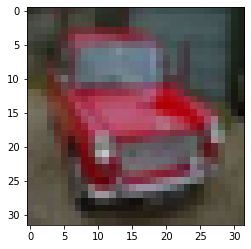

GroundTruth:  frog Predicted:  frog


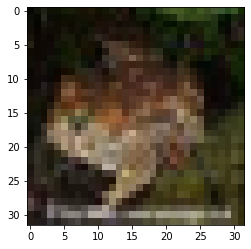

GroundTruth:  plane Predicted:  plane


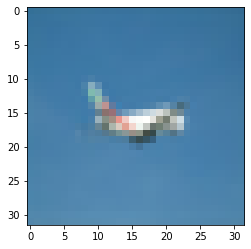

GroundTruth:  dog Predicted:  ship


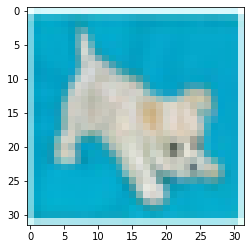

In [ ]:
# test
outputs = net(images_adv)
_, predicted = torch.max(outputs, 1)

for image, label, predict in zip(images_adv, labels, predicted):
    print('GroundTruth: ', classes[label], 'Predicted: ', classes[predict])
    imshow(image)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                # for j in range(4)))


In [ ]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
